<a href="https://colab.research.google.com/github/Drahtesel/Credit_Scoring_Prototypes/blob/main/Optimierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bayesian-optimization
!pip install scikit-optimize
from bayes_opt import BayesianOptimization

In [3]:
# ============================================================
# Optimierung und Visualisierung der Prototypen
# Dieses Notebook:
# Lädt die vorbereiteten Daten (X, y)
# Bereitet den Vergleich der Anforderungen an die Daten vor, indem
# die Merkmalsanzahl und Trainigsdatenmenge frei wählbar ist
#
# Führt eine Hyperparameteroptimierung mithilfe der Bayesian Optimization durch
#
# ============================================================
import os
import json
import math
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
from itertools import product
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import drive
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import norm
from itertools import combinations

# --- Modelle ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- Google Drive mount (Colab) ---
drive.mount('/content/drive', force_remount=False)

# --- Datenverzeichnis ----------------------------------------
data_dir = "/content/drive/MyDrive/Thesis/Daten/DataPreprocess/german_credit_prepared"

# --- Daten laden ---------------------------------------------
    # Je Feature Selection (FS) Variante
number_of_features = ["", "_FS_5", "_FS_10", "_FS_15"]
base_dir = "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results"

    # Auswahl der genutzten FS Variante
chosen_fs = number_of_features[3]

# Vorbereitung um Anzahl Beobachtungen zu begrenzen
data_split = [0.36, 0.54, 0.68, 0.84] # entspricht 100%, 75%, 50% und 50%
data_split_chosen = data_split[0]
percentage = ["100%", "75%", "50%", "25%"]
chosen_percentage = percentage[0]

X_directory, y_directory = "X_prepared"+chosen_fs+".csv", "y_labels"+chosen_fs+".csv"

X = pd.read_csv(os.path.join(data_dir, X_directory))
y = pd.read_csv(os.path.join(data_dir, y_directory))

# falls y als DataFrame mit 1 Spalte -> Series
if isinstance(y, pd.DataFrame):
    if y.shape[1] == 1 or y.shape[1] == 1:
        y = y.iloc[:, 0]
    else:
        # falls mehrere Spalten, versuche squeeze
        y = y.squeeze(), y.squeeze()

y = pd.Series(y).reset_index(drop=True)
X = X.reset_index(drop=True)
print("Daten geladen:", X.shape, y.shape)


# --- Einstellungen: Pfad auf Google Drive ---
base = base_dir + chosen_fs + "_" + chosen_percentage

output_dir = '/content/drive/MyDrive/Thesis/FINAL_RUN/Grafiken'
os.makedirs(base, exist_ok=True)

# --- Kreuzvalidierung über Stratified Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Models und farbliche Zuordnung ---
models = ["LR", "RF", "XGB", "NN"]

colors = {
    "LR": "tab:blue",
    "RF": "tab:green",
    "XGB": "tab:red",
    "NN": "tab:purple"
}

# --- Train/Test Split ---
X_dummy, X_test, y_dummy, y_test = train_test_split(
    X, y, test_size=0.36, random_state=42, stratify=y
)

X_train, X_dummy, y_train, y_dummy = train_test_split(
    X, y, test_size=(data_split_chosen), random_state=42, stratify=y
)

print("Trainingsdaten:", X_train.shape, y_train.shape)

# ------------------------------------------------------------------
# Hilfsfunktionen
# ------------------------------------------------------------------

# Negativer logarithmischer Loss, da das genutzte Bayesian Optimization Package
# nur maximieren kann
def cv_neg_log_loss(model, X_local, y_local):
    """Cross-validated negative log-loss"""
    try:
        scores = cross_val_score(model, X_local, y_local, cv=cv, scoring="neg_log_loss", n_jobs=-1)
        return float(np.mean(scores))
    except Exception as e:
        print("Error during CV:", e)
        return -10.0

# Konvertiert gängige Numpy und Pandas Datentypen in Python Datentypen um eine einfache
# Abspeicherung zu erlauben
def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {make_json_serializable(k): make_json_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [make_json_serializable(x) for x in obj]
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if pd.isna(obj):
        return None
    return obj

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(make_json_serializable(obj), f, indent=2)

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def pad_histories(histories):
    """Pad lists to equal length by repeating last value."""
    if len(histories) == 0:
        return np.zeros((1,1))
    max_len = max(len(h) for h in histories)
    padded = np.array([h + [h[-1]] * (max_len - len(h)) for h in histories], dtype=float)
    return padded

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Daten geladen: (1000, 42) (1000,)
Trainingsdaten: (640, 42) (640,)


In [4]:
# @title Modelldefinitionen
# Instanziierung und Konfiguration der Prototypen

def create_model(model_name, params):
  # --- logistische Regression ---
    if model_name == "LR":
        penalty = {0: None, 1: "l1", 2: "l2", 3: "elasticnet"}[int(round(params["penalty_num"]))]
        solver = "saga" if penalty in [None, "elasticnet"] else "liblinear"
        model = LogisticRegression(
            penalty=penalty,
            C=float(params["C"]),
            l1_ratio=0.5 if penalty == "elasticnet" else None,
            solver=solver,
            max_iter=int(params["max_iter"]),
            intercept_scaling=1.0,
            random_state=42 if solver == "liblinear" else None,
        )

# --- Random Forest ---
    elif model_name == "RF":
        model = RandomForestClassifier(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            min_samples_split=int(params["min_samples_split"]),
            min_samples_leaf=int(params["min_samples_leaf"]),
            max_features=int(params["max_features"]),
            bootstrap=True,
            criterion={0: "log_loss", 1: "gini", 2: "entropy"}[int(round(params["criterion_num"]))],
            random_state=42,
            n_jobs=-1
        )

# --- XGBoost ---
    elif model_name == "XGB":
        model = XGBClassifier(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            learning_rate=float(params["learning_rate"]),
            subsample=float(params["subsample"]),
            eval_metric={0: "logloss", 1: "auc"}[int(round(params["eval_num"]))],
            colsample_bytree=float(params["colsample_bytree"]),
            gamma=float(params["gamma"]),
            min_child_weight=float(params["min_child_weight"]),
            reg_alpha=float(params["reg_alpha"]),
            reg_lambda=float(params["reg_lambda"]),
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )

# --- Neuronales Netz ---
    elif model_name == "NN":
        hidden_layers = tuple([int(params["n_neurons"])] * int(round(params["n_layers"])))
        model = Pipeline(
            [("scaler", StandardScaler()),
            ("mlp", MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                alpha=float(params["alpha"]),
                learning_rate_init=float(params["learning_rate_init"]),
                learning_rate={0:"constant", 1:"invscaling", 2:"adaptive"}[int(round(params["learning_rate_idx"]))],
                batch_size=int(params["batch_size"]),
                max_iter=int(params["max_iter"]),
                early_stopping=True,
                activation={0: "relu", 1: "tanh", 2: "logistic"}[int(round(params["activation_num"]))],
                random_state=42,
            ))]
        )

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model

In [5]:
# @title Modellobjekte
# Nimmt die während der Bayesian Optimization gefundenen Hyperparameterkombinationen entgegen,
# erstellt neue Modelle mit diesen Hyperparametern und bewertet sie durch den logarithmischen Loss

def lr_obj(penalty_num, C, max_iter):
    params = {
        "penalty_num": penalty_num,
        "C": C,
        "max_iter": max_iter,
    }
    model = create_model("LR", params)
    return cv_neg_log_loss(model, X_train, y_train)


def rf_obj(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, criterion_num):
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
        "criterion_num": criterion_num,
    }
    model = create_model("RF", params)
    return cv_neg_log_loss(model, X_train, y_train)


def xgb_obj(n_estimators, max_depth, learning_rate, subsample, eval_num,
            colsample_bytree, gamma, min_child_weight, reg_alpha, reg_lambda):

    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "eval_num": eval_num,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "min_child_weight": min_child_weight,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
    }
    model = create_model("XGB", params)
    return cv_neg_log_loss(model, X_train, y_train)


def nn_obj(n_layers, n_neurons, alpha, learning_rate_init,
           learning_rate_idx, batch_size, max_iter, activation_num):
    params = {
        "n_layers": n_layers,
        "n_neurons": n_neurons,
        "alpha": alpha,
        "learning_rate_init": learning_rate_init,
        "learning_rate_idx": learning_rate_idx,
        "batch_size": batch_size,
        "max_iter": max_iter,
        "activation_num": activation_num,
    }
    model = create_model("NN", params)
    return cv_neg_log_loss(model, X_train, y_train)

# Optimierung der Modelle

In [6]:
# @title Während der BO untersuchte Intervalle je Hyperparamter
N_RUNS = 10

MODEL_BO_CONFIG = {
    "LR": {
      "func": lr_obj,
      "pbounds": {
          "penalty_num": (0, 3),
          "C": (1e-3, 10),
          "max_iter": (300, 1500),
      },
    "init_points": 10,
    "n_iter": 40
    },

    "RF": {
      "func": rf_obj,
      "pbounds": {
          "n_estimators": (50, 500),
          "max_depth": (2, 25),
          "min_samples_split": (2, 10),
          "min_samples_leaf": (1, 10),
          "max_features": (2, 10),
          "criterion_num": (0, 2),
      },
    "init_points": 10,
    "n_iter": 40
    },

    "XGB": {
      "func": xgb_obj,
      "pbounds": {
          "n_estimators": (50, 300),
          "max_depth": (2, 8),
          "learning_rate": (0.01, 0.3),
          "subsample": (0.5, 1.0),
          "eval_num": (0, 1),
          "colsample_bytree": (0.5, 1.0),
          "gamma": (0, 5),
          "min_child_weight": (1, 10),
          "reg_alpha": (0.0, 5.0),
          "reg_lambda": (0.0, 5.0),
      },
    "init_points": 10,
    "n_iter": 40
    },

    "NN": {
      "func": nn_obj,
      "pbounds": {
          "n_layers": (1, 4),
          "n_neurons": (8, 64),
          "alpha": (1e-6, 1e-2),
          "learning_rate_init": (1e-4, 0.1),
          "learning_rate_idx": (0, 2),
          "batch_size": (16, 128),
          "max_iter": (300, 1500),
          "activation_num": (0, 2),
      },
    "init_points": 10,
    "n_iter": 40
    }
}

In [ ]:
# title Hilfsmethoden zur Verarbeitung und Speicherung der Ergebnisse

# Speichert die detaillierte Historie einer BO-Iteration als JSON und CSV.
def _save_iteration_history(run_dir, iteration_details):

    # iteration_details in ein serialisierbares Format konvertieren
    serializable_iteration_details = [
        {k: make_json_serializable(v) for k, v in item.items()}
        for item in iteration_details
    ]
    save_json(serializable_iteration_details, os.path.join(run_dir, "history.json"))

    rows = []
    for r in iteration_details:
        row = {}
        for k, v in r["params"].items():
            if isinstance(v, (np.integer,)):
                row[k] = int(v)
            elif isinstance(v, (np.floating,)):
                row[k] = float(v)
            else:
                try:
                    row[k] = float(v)
                except Exception:
                    row[k] = v
        row["target"] = float(r["target"])
        row["time_taken_seconds"] = float(r["time_taken_seconds"])
        rows.append(row)
    df_hist = pd.DataFrame(rows)
    df_hist.to_csv(os.path.join(run_dir, "history.csv"), index=False)

# Speichert die Zusammenfassung des besten Ergebnisses für einen einzelnen Lauf.
def _save_run_summary(run_dir, bo_max_result, iteration_details, elapsed_time_run, run_idx):

    best_params = make_json_serializable(bo_max_result["params"])
    best_target = float(bo_max_result["target"])

    run_summary = {
        "run": run_idx,
        "best_target": best_target,
        "best_params": best_params,
        "n_iterations": len(iteration_details),
        "iteration_of_best": int(np.argmax([r["target"] for r in iteration_details]) + 1),
        "run_time_seconds": elapsed_time_run
    }
    save_json(run_summary, os.path.join(run_dir, "best_summary.json"))
    return run_summary

# Behandelt den Fall, wenn keine Historien gesammelt wurden.
def _handle_no_histories(name, model_dir):

    print(f"[{name}] No histories collected for model. Cannot aggregate.")
    pd.DataFrame().to_csv(os.path.join(model_dir, "aggregated_history.csv"), index=False)
    pd.DataFrame().to_csv(os.path.join(model_dir, "run_summaries.csv"), index=False)
    meta = {
        "model": name, "n_runs": 0, "mean_best_target": -np.inf, "median_best_target": -np.inf,
        "std_best_target": 0.0, "ci95_lower_best": -np.inf, "ci95_upper_best": -np.inf,
        "mean_run_time_seconds": 0.0, "std_run_time_seconds": 0.0
    }
    save_json(meta, os.path.join(model_dir, "meta_summary.json"))
    pd.DataFrame([meta]).to_csv(os.path.join(model_dir, "meta_summary.csv"), index=False)
    print(f"[{name}] done (no valid runs). Results in: {model_dir}")
    return {
        "model": name,
        "model_dir": model_dir,
        "aggregated_history": pd.DataFrame(),
        "run_summaries": pd.DataFrame(),
        "meta": meta
    }

# Aggregiert die Historien aller Läufe und speichert die Ergebnisse.
def _aggregate_and_save_histories(model_dir, all_histories):

    padded = pad_histories(all_histories)
    mean_curve = padded.mean(axis=0)
    std_curve = padded.std(axis=0)
    sem_curve = std_curve / math.sqrt(len(all_histories))
    ci95_upper = mean_curve + 1.96 * sem_curve
    ci95_lower = mean_curve - 1.96 * sem_curve

    agg_df = pd.DataFrame({
        "mean_target": mean_curve,
        "std_target": std_curve,
        "sem_target": sem_curve,
        "ci95_upper": ci95_upper,
        "ci95_lower": ci95_lower
    })
    agg_df_path = os.path.join(model_dir, "aggregated_history.csv")
    agg_df.to_csv(agg_df_path, index=False)
    return agg_df

# Speichert die aggregierten Laufergebnisse und die Meta-Zusammenfassung.
def _save_summaries_and_meta(model_dir, name, run_summaries, all_run_times):

    run_summaries_df = pd.DataFrame(run_summaries)
    run_summaries_df.to_csv(os.path.join(model_dir, "run_summaries.csv"), index=False)

    best_targets = run_summaries_df["best_target"].values
    meta = {
        "model": name,
        "n_runs": len(run_summaries_df),
        "mean_best_target": float(np.mean(best_targets)),
        "median_best_target": float(np.median(best_targets)),
        "std_best_target": float(np.std(best_targets, ddof=1)) if len(best_targets) > 1 else 0.0,
        "ci95_lower_best": float(np.mean(best_targets) - 1.96 * (np.std(best_targets, ddof=1) / math.sqrt(len(best_targets)))) if len(best_targets) > 1 else float(np.mean(best_targets)),
        "ci95_upper_best": float(np.mean(best_targets) + 1.96 * (np.std(best_targets, ddof=1) / math.sqrt(len(best_targets)))) if len(best_targets) > 1 else float(np.mean(best_targets)),
        "mean_run_time_seconds": float(np.mean(all_run_times)),
        "std_run_time_seconds": float(np.std(all_run_times, ddof=1)) if len(all_run_times) > 1 else 0.0
    }
    save_json(meta, os.path.join(model_dir, "meta_summary.json"))
    pd.DataFrame([meta]).to_csv(os.path.join(model_dir, "meta_summary.csv"), index=False)
    return run_summaries_df, meta

In [8]:
# @title Optimierungsmethode

# diese Methode ist die eigentlich Bayesian Optimization, sie wird für jedes Modell aufgerufen
def run_bo_model(name, cfg, X_train_current, y_train_current, current_output_base, n_runs=N_RUNS, verbose=True):

    model_dir = os.path.join(current_output_base, name)
    ensure_dir(model_dir)

    all_histories = []
    run_summaries = []
    all_run_times = []

    # Führt die übergebene Anzahl an Optimierungsläufen durch
    for run_idx in tqdm(range(1, n_runs + 1), desc=f"Runs for {name} ({os.path.basename(current_output_base)})"):
        start_time_run = time.time()

        bo = BayesianOptimization(
            f=cfg["func"],
            pbounds=cfg["pbounds"],
            random_state=run_idx * 31 + 7,
            verbose=0
        )

        iteration_details = [] # Speichert Details jeder Iteration inklusive Zeit

        # Führt die initialen Iterationen aus
        for i in range(cfg["init_points"]):
            iter_start_time = time.time()
            bo.maximize(init_points=1, n_iter=0) # Führt einen Initialpunkt aus
            iter_end_time = time.time()
            last_entry = bo.res[-1]
            last_entry['time_taken_seconds'] = iter_end_time - iter_start_time
            iteration_details.append(last_entry)

        # Führt die Iterationen aus
        for i in range(cfg["n_iter"]):
            iter_start_time = time.time()
            bo.maximize(init_points=0, n_iter=1)
            iter_end_time = time.time()
            last_entry = bo.res[-1]
            last_entry['time_taken_seconds'] = iter_end_time - iter_start_time
            iteration_details.append(last_entry)

        end_time_run = time.time()
        elapsed_time_run = end_time_run - start_time_run
        all_run_times.append(elapsed_time_run)

        # --- Verarbeitung und Speicherung der Ergebnisse pro Lauf ---
        if len(iteration_details) == 0:
            print(f"[{name}] Warning: no history for run {run_idx}. Skipping.")
            continue

        hist_values = [float(r["target"]) for r in iteration_details]
        all_histories.append(hist_values)

        run_dir = os.path.join(model_dir, f"run_{run_idx:02d}")
        ensure_dir(run_dir)

        _save_iteration_history(run_dir, iteration_details)

        run_summary = _save_run_summary(run_dir, bo.max, iteration_details, elapsed_time_run, run_idx)
        run_summaries.append(run_summary)

    # --- Aggregation der erstellten history-Dateien und Meta-Daten ---
    if len(all_histories) == 0:
        return _handle_no_histories(name, model_dir)

    agg_df = _aggregate_and_save_histories(model_dir, all_histories)
    run_summaries_df, meta = _save_summaries_and_meta(model_dir, name, run_summaries, all_run_times)

    print(f"[{name}] done. Results in: {model_dir}")
    return {
        "model": name,
        "model_dir": model_dir,
        "aggregated_history": agg_df,
        "run_summaries": run_summaries_df,
        "meta": meta
    }

In [ ]:
# @title Durchführung der Optimierung
name = "BO_Results" + chosen_fs + "_" + chosen_percentage

print(f"\n{'='*80}")
print(f"Starte Bayes'sche Optimierung für aktuell geladenes Feature Set: {name}")
print(f"{'='*80}")

os.makedirs(base, exist_ok=True)
model_current = deepcopy(MODEL_BO_CONFIG)

# max_features muss an die Anzahl Features im Datensatz angepasst werden
if "RF" in model_current:
    model_current["RF"]["pbounds"]["max_features"] = (2, X_train.shape[1])
    print(f"Aktualisiert RF max_features für {name} auf (2, {X_train.shape[1]}) (Anzahl der Features: {X_train.shape[1]}) ")

results_current = {}
for model_name, cfg in model_current.items():
    print("\n" + "="*60)
    print(f"Starte BO-Läufe für {model_name} mit {N_RUNS} Läufen (Feature Set: {name})")

    results_current[model_name] = run_bo_model(
        model_name, cfg, X_train, y_train, base, n_runs=N_RUNS
    )
    print(f"Fertig {model_name} für {name}")

# Speichern der aggregierten Meta-Daten
meta_data = {m: results_current[m]["meta"] for m in results_current}
save_json(meta_data, os.path.join(base, "all_models_meta.json"))
pd.DataFrame([meta_data[m] for m in meta_data]).to_csv(os.path.join(base, "all_models_meta.csv"), index=False)

print(f"\nAlle Bayes'schen Optimierungsläufe für {name} abgeschlossen. Ergebnisse gespeichert unter: {base}")



Starte Bayes'sche Optimierung für aktuell geladenes Feature Set: BO_Results_FS_15_100%
Aktualisiert RF max_features für BO_Results_FS_15_100% auf (2, 42) (Anzahl der Features: 42) 

Starte BO-Läufe für LR mit 10 Läufen (Feature Set: BO_Results_FS_15_100%)


Runs for LR (BO_Results_FS_15_100%): 100%|██████████| 10/10 [05:10<00:00, 31.05s/it]


[LR] done. Results in: /content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%/LR
Fertig LR für BO_Results_FS_15_100%

Starte BO-Läufe für RF mit 10 Läufen (Feature Set: BO_Results_FS_15_100%)


Runs for RF (BO_Results_FS_15_100%): 100%|██████████| 10/10 [36:28<00:00, 218.84s/it]


[RF] done. Results in: /content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%/RF
Fertig RF für BO_Results_FS_15_100%

Starte BO-Läufe für XGB mit 10 Läufen (Feature Set: BO_Results_FS_15_100%)


Runs for XGB (BO_Results_FS_15_100%): 100%|██████████| 10/10 [10:31<00:00, 63.11s/it]


[XGB] done. Results in: /content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%/XGB
Fertig XGB für BO_Results_FS_15_100%

Starte BO-Läufe für NN mit 10 Läufen (Feature Set: BO_Results_FS_15_100%)


Runs for NN (BO_Results_FS_15_100%): 100%|██████████| 10/10 [11:37<00:00, 69.80s/it]


[NN] done. Results in: /content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%/NN
Fertig NN für BO_Results_FS_15_100%

Alle Bayes'schen Optimierungsläufe für BO_Results_FS_15_100% abgeschlossen. Ergebnisse gespeichert unter: /content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%


# Trainieren der Hyperparameterkombinationen

In [ ]:
# @title Training der Hyperparameterkombinationen
warnings.filterwarnings('ignore')
N_SPLITS = 10  # Anzahl Splits in der Kreuzvalidierung

fs_name = chosen_fs + "_" + chosen_percentage

print(f"\n{'='*60}")
print(f"Calculating metrics for Feature Set: {fs_name}")
print(f"{'='*60}")
out_dir_metrics = os.path.join(base, "metrics_per_iteration")
os.makedirs(out_dir_metrics, exist_ok=True)

# Für jedes Modell
for m in tqdm(models, desc=f"Models for {fs_name}"):
    print(f"\n === Verarbeite Modell: {m} f\u00fcr FS: {fs_name} ===")
    model_dir = os.path.join(base, m)
    all_metrics = []

    if not os.path.isdir(model_dir) or not any(os.path.isdir(os.path.join(model_dir, d)) and d.startswith("run_") for d in os.listdir(model_dir)):
        print(f"No runs found for model {m} in {fs_name}. Skipping metric calculation for this model/FS combination.")
        continue

    run_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d)) and d.startswith("run_")]
    if not run_dirs:
        print(f"No valid run directories found for model {m} in {fs_name}. Skipping metric calculation.")
        continue

    # und jeden Run
    for run in tqdm(run_dirs, desc=f"Runs for {m}"):
        hist_path = os.path.join(model_dir, run, "history.csv")
        if not os.path.exists(hist_path):
            continue

        df_hist = pd.read_csv(hist_path)

        # wird jede Hyperparameterkombination trainiert
        for idx, row in df_hist.iterrows():
            params = row.drop("target").to_dict()
            model = create_model(m, params)

            skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

            aucs, accs, train_times = [], [], []

            for train_idx, test_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

                start_train_time = time.time() # Zeit messen
                model.fit(X_tr, y_tr)
                end_train_time = time.time()
                train_times.append(end_train_time - start_train_time)

                y_proba = model.predict_proba(X_val)[:, 1]
                y_pred = (y_proba >= 0.5).astype(int)

                aucs.append(roc_auc_score(y_val, y_proba))
                accs.append(accuracy_score(y_val, y_pred))

            all_metrics.append({
                "run": run,
                "iteration": idx + 1,
                "target_neg_log_loss": row["target"],
                "auc_mean": np.mean(aucs),
                "auc_std":  np.std(aucs),
                "accuracy_mean": np.mean(accs),
                "accuracy_std":  np.std(accs),
                "train_time_mean_seconds": np.mean(train_times),
                "train_time_std_seconds": np.std(train_times),
                **params
            })

    if all_metrics:
        df_metrics = pd.DataFrame(all_metrics)
        df_metrics.to_csv(os.path.join(out_dir_metrics, f"{m}_metrics.csv"), index=False)
    else:
        print(f"No metrics calculated for model {m} in {fs_name}.")


Calculating metrics for Feature Set: _FS_15_25%


Models for _FS_15_25%:   0%|          | 0/4 [00:00<?, ?it/s]


 === Verarbeite Modell: LR für FS: _FS_15_25% ===



Models for _FS_15_25%:  25%|██▌       | 1/4 [02:03<06:11, 123.71s/it]


 === Verarbeite Modell: RF für FS: _FS_15_25% ===



Models for _FS_15_25%:  50%|█████     | 2/4 [36:38<42:22, 1271.46s/it]


 === Verarbeite Modell: XGB für FS: _FS_15_25% ===



Models for _FS_15_25%:  75%|███████▌  | 3/4 [41:04<13:32, 812.47s/it] 


 === Verarbeite Modell: NN für FS: _FS_15_25% ===



Models for _FS_15_25%: 100%|██████████| 4/4 [44:00<00:00, 660.11s/it]


In [ ]:
# @title Ergebnisse des Vergleichs der Feature-Selection
# Alle Feature Selection Runs werden durchsucht und die besten 10 Runs je Feature-Selection-Split
# werden zurückgegeben. Diese werden für den Vergleich der Datenanforderungen in Kapitel 5.1 genutzt.
#

FS_FOLDERS = {
    5:  "/content/drive/MyDrive/Thesis/BO_Results_FS_5",
    10: "/content/drive/MyDrive/Thesis/BO_Results_FS_10",
    15: "/content/drive/MyDrive/Thesis/BO_Results_FS_15",
    20: "/content/drive/MyDrive/Thesis/BO_Results",
}

# Läd die Daten aus den angegebenen Runs
def load_metrics_for_model(model):
    rows = []

    for fs, folder in FS_FOLDERS.items():
        file_path = os.path.join(folder, "metrics_per_iteration", f"{model}_metrics.csv")
        if not os.path.exists(file_path):
            print(f"[WARN] File missing: {file_path}")
            continue

        df = pd.read_csv(file_path)

        row = {
            "Features": fs,
            "AUC": f"{df['auc_mean'].sort_values(ascending=False).head(10).mean():.4f} ± {df['auc_std'].sort_values(ascending=False).head(10).mean():.4f}",
            "Accuracy": f"{df['accuracy_mean'].sort_values(ascending=False).head(10).mean():.4f} ± {df['accuracy_std'].sort_values(ascending=False).head(10).mean():.4f}",
        }
        rows.append(row)

    return pd.DataFrame(rows).sort_values("Features")

all_tables = {}

for m in models:
    table = load_metrics_for_model(m)
    all_tables[m] = table
    print(f"\n==== {m} ====\n")
    print(table.to_string(index=False))


==== LR ====

 Features             AUC        Accuracy
        5 0.7557 ± 0.0655 0.6858 ± 0.1930
       10 0.7667 ± 0.0571 0.7203 ± 0.1983
       15 0.7805 ± 0.0534 0.7359 ± 0.1983
       20 0.7816 ± 0.0542 0.7334 ± 0.1951

==== RF ====

 Features             AUC        Accuracy
        5 0.7649 ± 0.0633 0.7427 ± 0.0636
       10 0.7856 ± 0.0631 0.7562 ± 0.0491
       15 0.7906 ± 0.0622 0.7617 ± 0.0604
       20 0.7890 ± 0.0699 0.7608 ± 0.0649

==== XGB ====

 Features             AUC        Accuracy
        5 0.7609 ± 0.0658 0.7345 ± 0.0665
       10 0.7779 ± 0.0733 0.7484 ± 0.0653
       15 0.7839 ± 0.0717 0.7522 ± 0.0543
       20 0.7829 ± 0.0739 0.7519 ± 0.0566

==== NN ====

 Features             AUC        Accuracy
        5 0.7538 ± 0.1879 0.7341 ± 0.1070
       10 0.7685 ± 0.1632 0.7456 ± 0.1231
       15 0.7782 ± 0.1704 0.7477 ± 0.1124
       20 0.7827 ± 0.2021 0.7475 ± 0.1161


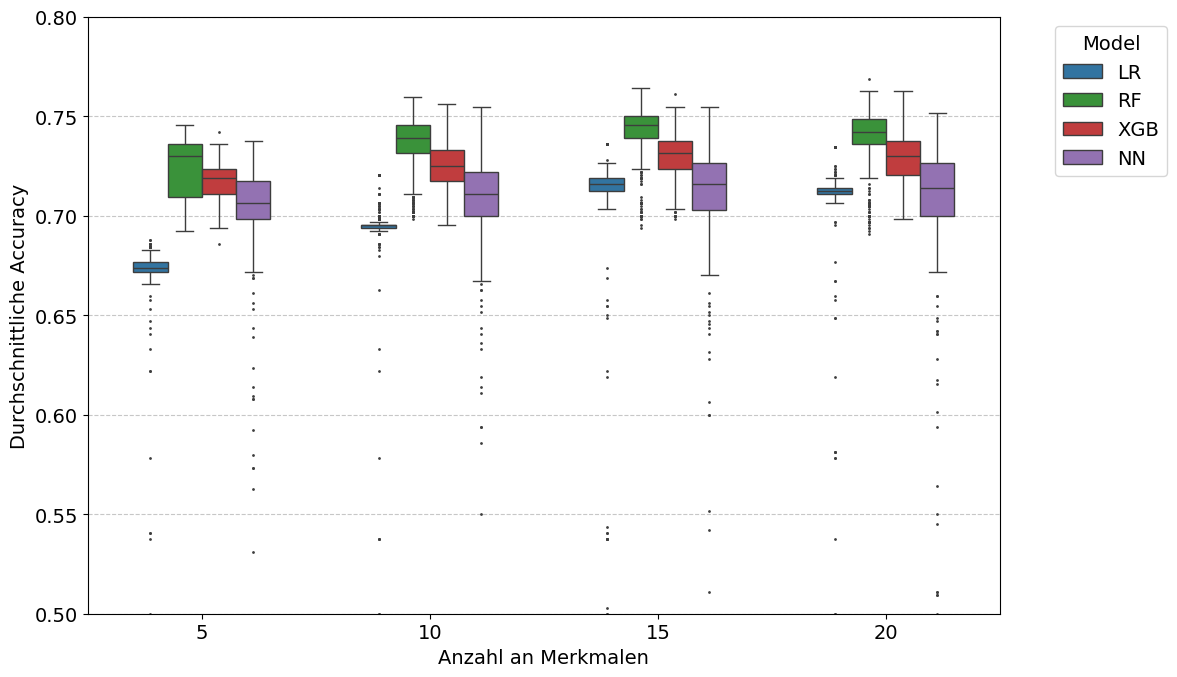

In [ ]:
# @title Visualisierung Feature-Selection-Vergleich

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

plt.rcParams.update({'font.size': 14})
parent_bo_results_dir = "/content/drive/MyDrive/Thesis/"

fs_configs = {
    "": 20,
    "_FS_5": 5,
    "_FS_10": 10,
    "_FS_15": 15
}

all_metrics_data = []

for fs_key, fs_size in fs_configs.items():
    bo_run_folder = os.path.join(parent_bo_results_dir, "BO_Results" + fs_key)
    metrics_per_iteration_dir = os.path.join(bo_run_folder, "metrics_per_iteration")

    if not os.path.exists(metrics_per_iteration_dir):
        print(f"Warning: Metrics directory not found for {fs_key if fs_key else 'Full_FS'} at {metrics_per_iteration_dir}")
        continue

    for m in models:
        file_path = os.path.join(metrics_per_iteration_dir, f"{m}_metrics.csv")
        if os.path.exists(file_path):
            df_m = pd.read_csv(file_path)
            df_m["model"] = m
            df_m["Features"] = fs_size # Use the numeric feature size for sorting
            all_metrics_data.append(df_m)
        else:
            print(f"Warning: Metrics file not found for {m} in {fs_key} at {file_path}")

if all_metrics_data:
    combined_metrics_df = pd.concat(all_metrics_data, ignore_index=True)

    plt.figure(figsize=(12, 7))
    sns.boxplot(
        data=combined_metrics_df,
        x="Features",
        y="accuracy_mean",
        hue="model",
        palette=colors,
        width=0.6,
        linewidth=1.0,
        fliersize=1
    )
    plt.xlabel("Anzahl an Merkmalen")
    plt.ylabel("Durchschnittliche Accuracy")
    plt.grid(axis="y", linestyle='--', alpha=0.7)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0.5, 0.8)
    plt.tight_layout()

    fig_name_FS_ACC = f"Accuracy_FS_Comparison.png"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, fig_name_FS_ACC))
    plt.show()
else:
    print("No combined metrics data found to plot for Feature Selection comparison.")

In [ ]:
# @title Ergebnisse des Vergleichs der Trainingsdatenmenge
# Alle Runs mit unterschiedlichen Trainingsdatenmenge werden durchsucht und die besten 10 Runs je
# Trainingsdatenmenge werden zurückgegeben. Diese werden für den Vergleich der Datenanforderungen
# in Kapitel 5.1 genutzt.
#

DICTIONARIES = {
    100: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%",
    75: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_75%",
    50: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_50%",
    25: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_25%",
}

# Läd die Daten aus den angegebenen Runs
def load_metrics_for_model(model):
    rows = []

    for fs, folder in DICTIONARIES.items():
        file_path = os.path.join(folder, "metrics_per_iteration", f"{model}_metrics.csv")
        if not os.path.exists(file_path):
            print(f"[WARN] File missing: {file_path}")
            continue

        df = pd.read_csv(file_path)

        row = {
            "Features": fs,
            "AUC": f"{df['auc_mean'].sort_values(ascending=False).head(10).mean():.4f} ± {df['auc_std'].sort_values(ascending=False).head(10).mean():.4f}",
            "Accuracy": f"{df['accuracy_mean'].sort_values(ascending=False).head(10).mean():.4f} ± {df['accuracy_std'].sort_values(ascending=False).head(10).mean():.4f}",
        }
        rows.append(row)

    return pd.DataFrame(rows).sort_values("Features")

all_tables = {}

for m in models:
    table = load_metrics_for_model(m)
    all_tables[m] = table
    print(f"\n==== {m} ====\n")
    print(table.to_string(index=False))


==== LR ====

 Features             AUC        Accuracy
       25 0.7405 ± 0.1454 0.7456 ± 0.1147
       50 0.7699 ± 0.1264 0.7488 ± 0.0786
       75 0.7858 ± 0.0945 0.7526 ± 0.0614
      100 0.7827 ± 0.0498 0.7408 ± 0.0499

==== RF ====

 Features             AUC        Accuracy
       25 0.7162 ± 0.1176 0.7525 ± 0.0730
       50 0.7613 ± 0.1314 0.7634 ± 0.0764
       75 0.7822 ± 0.0924 0.7535 ± 0.0624
      100 0.7901 ± 0.0633 0.7595 ± 0.0605

==== XGB ====

 Features             AUC        Accuracy
       25 0.7035 ± 0.1545 0.7700 ± 0.0942
       50 0.7629 ± 0.1520 0.7638 ± 0.0802
       75 0.7824 ± 0.0960 0.7641 ± 0.0616
      100 0.7818 ± 0.0715 0.7492 ± 0.0536

==== NN ====

 Features             AUC        Accuracy
       25 0.7443 ± 0.2272 0.7412 ± 0.1471
       50 0.7774 ± 0.1894 0.7559 ± 0.1397
       75 0.7761 ± 0.2008 0.7443 ± 0.1073
      100 0.7774 ± 0.2277 0.7480 ± 0.1127


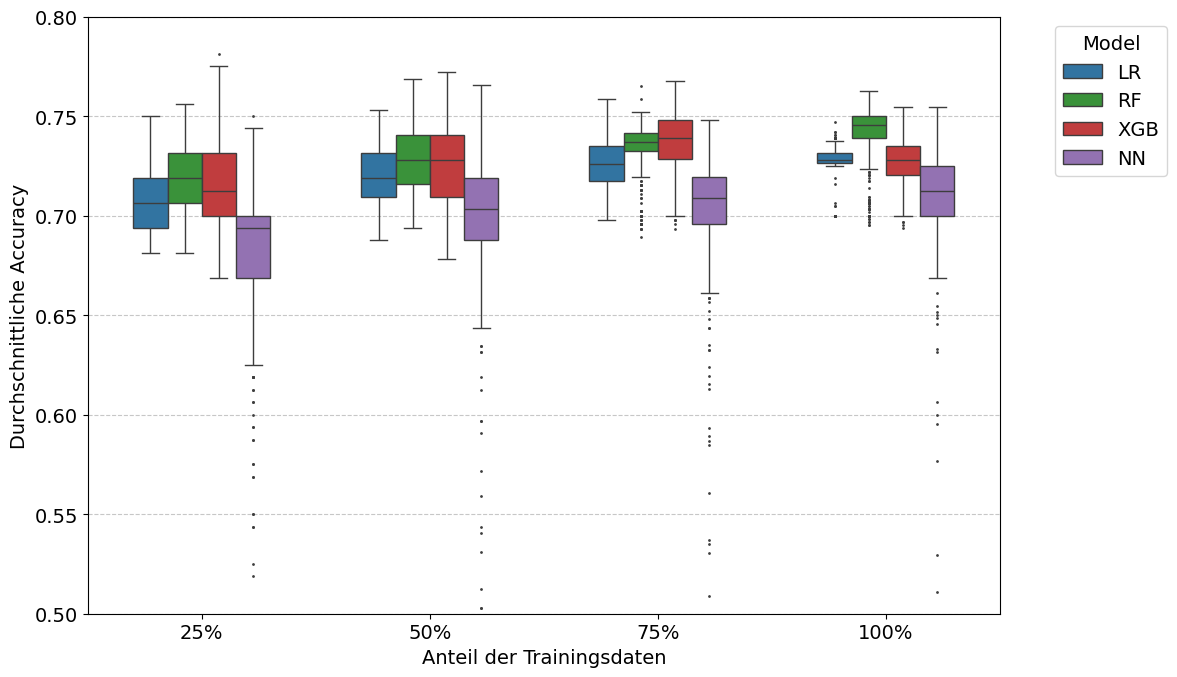

In [ ]:
# @title Visualisierung Trainingsdatenvergleich
plt.rcParams.update({'font.size': 14}) # Match previous plot's font size

percentage_folders = {
    100: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_100%",
    75: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_75%",
    50: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_50%",
    25: "/content/drive/MyDrive/Thesis/FINAL_RUN/BO_Results_FS_15_25%",
}

all_metrics_data_percentage = []

for percentage, folder_path in percentage_folders.items():
    metrics_per_iteration_dir = os.path.join(folder_path, "metrics_per_iteration")

    if not os.path.exists(metrics_per_iteration_dir):
        print(f"Warning: Metrics directory not found for {percentage}% at {metrics_per_iteration_dir}")
        continue

    for m in models:
        file_path = os.path.join(metrics_per_iteration_dir, f"{m}_metrics.csv")
        if os.path.exists(file_path):
            df_m = pd.read_csv(file_path)
            df_m["model"] = m
            df_m["Training Data Percentage"] = percentage
            all_metrics_data_percentage.append(df_m)
        else:
            print(f"Warning: Metrics file not found for {m} in {percentage}% at {file_path}")

if all_metrics_data_percentage:
    combined_metrics_df_percentage = pd.concat(all_metrics_data_percentage, ignore_index=True)

    plt.figure(figsize=(12, 7))
    sns.boxplot(
        data=combined_metrics_df_percentage,
        x="Training Data Percentage",
        y="accuracy_mean",
        hue="model",
        palette=colors,
        width=0.6,
        linewidth=1.0,
        fliersize=1
    )

    plt.xlabel("Anteil der Trainingsdaten")
    plt.ylabel("Durchschnittliche Accuracy")
    plt.grid(axis="y", linestyle='--', alpha=0.7)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0.5, 0.8)

    current_ticks = plt.gca().get_xticks()
    plt.gca().set_xticks(current_ticks)

    sorted_percentages = sorted(combined_metrics_df_percentage['Training Data Percentage'].unique().tolist())
    current_labels = [f'{int(tick)}%' for tick in sorted_percentages]
    plt.gca().set_xticklabels(current_labels)

    plt.tight_layout()

    # Save the plot
    fig_name_TD_ACC = "Accuracy_TrainingData_Comparison.png"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, fig_name_TD_ACC))
    plt.show()
else:
    print("No combined metrics data found to plot for Training Data Percentage comparison.")


# Implementierungsaufwand

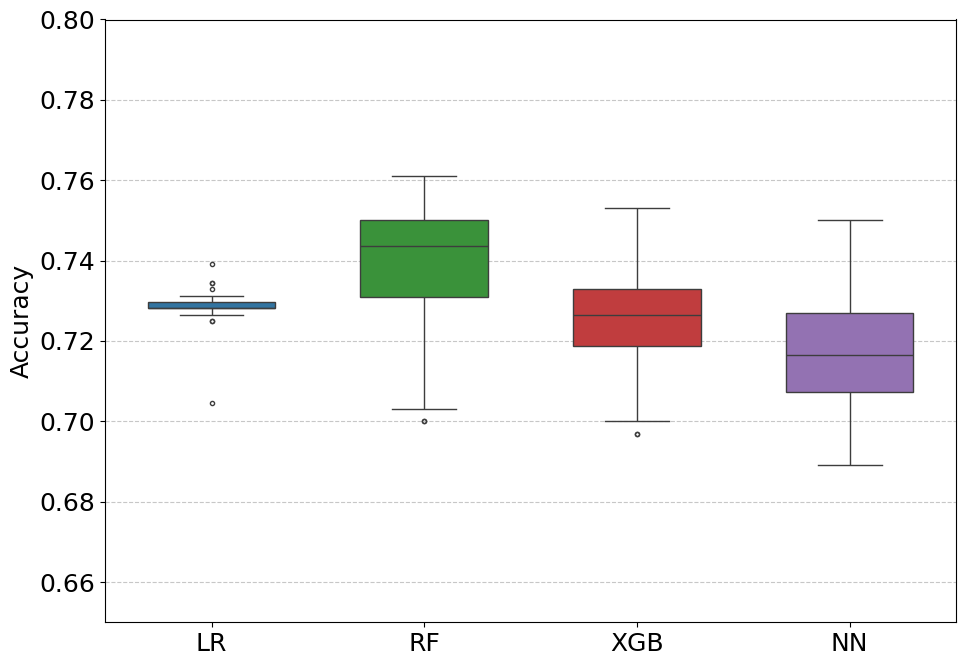

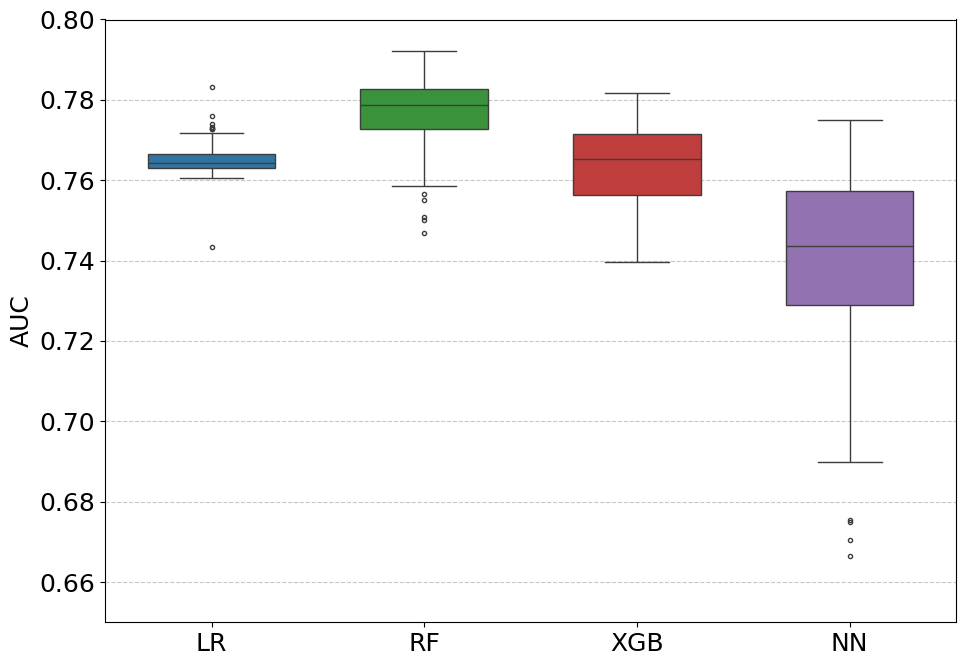

In [ ]:
# @title Visualisierung des Out-of-the-Box-Performance-Vergleichs

plt.rcParams.update({'font.size': 18})
metrics_dir = os.path.join(base, "metrics_per_iteration")
boxplot_data = []

if not os.path.isdir(metrics_dir):
    print(f"Error: Metrics directory not found at {metrics_dir}")
else:
    for model_name in models:
        metrics_file_path = os.path.join(metrics_dir, f"{model_name}_metrics.csv")

        if not os.path.exists(metrics_file_path):
            print(f"Warning: Metrics file not found for {model_name} at {metrics_file_path}")
            continue

        df_metrics = pd.read_csv(metrics_file_path)

        unique_runs = df_metrics['run'].unique()

        for run_id in unique_runs:
            df_run_initial = df_metrics[(df_metrics['run'] == run_id) & (df_metrics['iteration'] <= 10)]

            if not df_run_initial.empty:
                for index, row in df_run_initial.iterrows():
                    boxplot_data.append({
                        'Model': model_name,
                        'Metric': 'Accuracy',
                        'Value': row['accuracy_mean']
                    })
                    boxplot_data.append({
                        'Model': model_name,
                        'Metric': 'AUC',
                        'Value': row['auc_mean']
                    })

if boxplot_data:
    df_boxplot = pd.DataFrame(boxplot_data)

    # --- Boxplot for Accuracy ---
    plt.figure(figsize=(10, 7))
    sns.boxplot(
        data=df_boxplot[df_boxplot['Metric'] == 'Accuracy'],
        x='Model',
        y='Value',
        hue='Model',
        palette=colors,
        width=0.6,
        linewidth=1.0,
        fliersize=3,
        legend=False
    )
    plt.xlabel('')
    plt.ylabel('Accuracy')
    plt.ylim(0.65, 0.8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    fig_name_accuracy_oob_boxplot = "OOB_Accuracy_All10_Boxplot.png"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, fig_name_accuracy_oob_boxplot))
    plt.show()

    # --- Boxplot for AUC ---
    plt.figure(figsize=(10, 7))
    sns.boxplot(
        data=df_boxplot[df_boxplot['Metric'] == 'AUC'],
        x='Model',
        y='Value',
        hue='Model',
        palette=colors,
        width=0.6,
        linewidth=1.0,
        fliersize=3,
        legend=False
    )
    plt.xlabel('')
    plt.ylabel('AUC')
    plt.ylim(0.65, 0.8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    fig_name_auc_oob_boxplot = "OOB_AUC_All10_Boxplot.png"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, fig_name_auc_oob_boxplot))
    plt.show()
else:
    print("No data found to create out-of-the-box boxplots.")


Visualisierung der Optimierung mithilfe von Landschaftsdiagrammen

In [ ]:
# @title
# Um vollständige Landschaftsdiagramme erstellen zu könnne, muss mithilfe von Grid Search alle Kombination
# der gewählten Hyperparameterkombination optimiert werden. Dies wird im folgenden für RF, XGB und NN
# gemacht. Für LR ist dies nicht möglich aufgrund der geringen Anzahl an aussagekräftigen Hyperparametern.

#  Neuronales Netz Grid Search
n_layer = np.arange(1, 5, 1)
n_neurons = np.arange(8, 128, 6)
grid_NN = list(product(n_layer, n_neurons))
print(f"NN: {len(grid_NN)} Kombinationen")

results_NN = []

for layers, neurons in grid_NN:
    hidden_layers = tuple([neurons]*layers)
    model = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=2000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results_NN.append({
        "n_layers": layers,
        "n_neurons": neurons,
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba)
    })

df_NN = pd.DataFrame(results_NN)
df_NN.to_csv("/content/drive/MyDrive/Thesis/BO_Results/NN_grid_metrics.csv", index=False)
print(df_NN.head())

# XGBoost Grid Search
max_depth = np.arange(2, 21, 1)
n_estimators = np.arange(50, 501, 25)
grid_XGB = list(product(max_depth, n_estimators))
print(f"XGB: {len(grid_XGB)} Kombinationen")

results_XGB = []

for depth, n_est in grid_XGB:
    model = XGBClassifier(
        max_depth=depth,
        learning_rate=0.01,
        n_estimators=n_est,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results_XGB.append({
        "max_depth": depth,
        "n_estimators": n_est,
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba)
    })

df_XGB = pd.DataFrame(results_XGB)
df_XGB.to_csv("/content/drive/MyDrive/Thesis/BO_Results/XGB_grid_metrics.csv", index=False)
print(df_XGB.head())

# Random Forest Grid Search
max_depth = np.arange(2, 21, 1)
n_estimators = np.arange(50, 500, 25)
grid_RF = list(product(max_depth, n_estimators))
print(f"RF: {len(grid_RF)} Kombinationen")

results_RF = []

for depth, n_est in grid_RF:
    model = XGBClassifier(
        max_depth=depth,
        n_estimators=n_est,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results_RF.append({
        "max_depth": depth,
        "n_estimators": n_est,
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba),
        "log_loss": log_loss(y_test, y_proba)
    })

df_RF = pd.DataFrame(results_RF)
df_RF.to_csv("/content/drive/MyDrive/Thesis/BO_Results/RF_grid_metrics.csv", index=False)
print(df_RF.head())

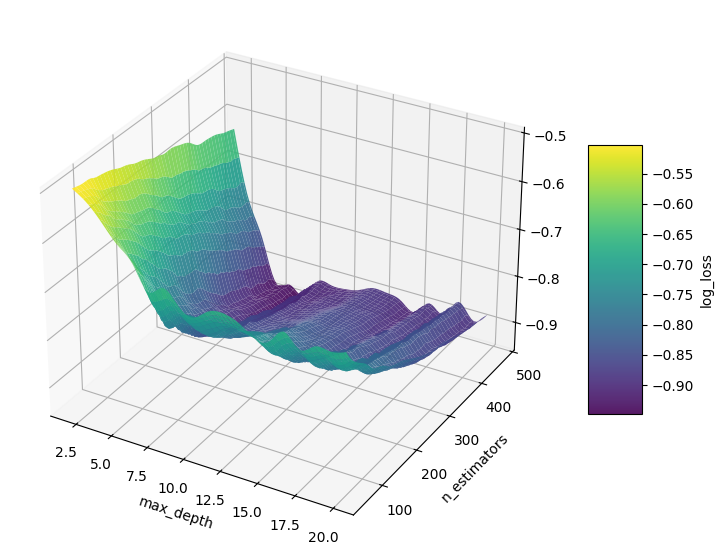

In [ ]:
# @title
df_RF = pd.read_csv('/content/drive/MyDrive/Thesis/BO_Results/RF_grid_metrics.csv')

x = df_RF['max_depth'].values
y = df_RF['n_estimators'].values
z = -df_RF['log_loss'].values

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
XI, YI = np.meshgrid(xi, yi)

# Interpolation
ZI = griddata((x, y), z, (XI, YI), method='cubic')

# 3D Plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XI, YI, ZI, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
fig.colorbar(surf, shrink=0.5, aspect=5, label='log_loss')
plt.savefig(f"{output_dir}/RF_landscape_log_loss.png")
plt.show()


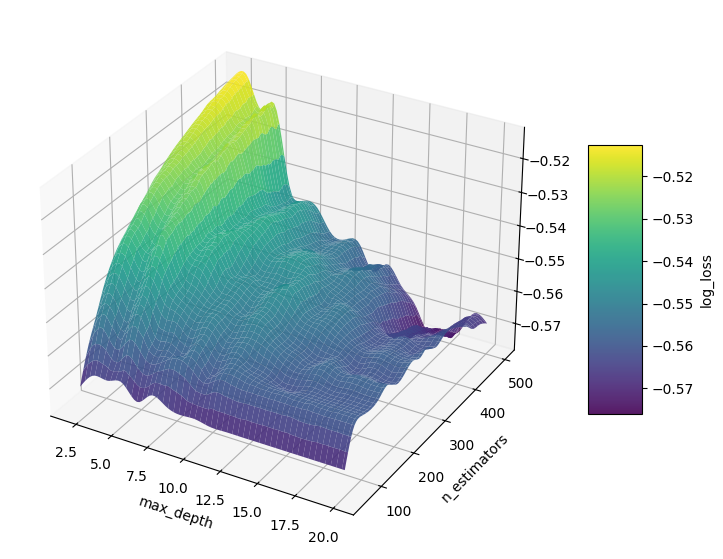

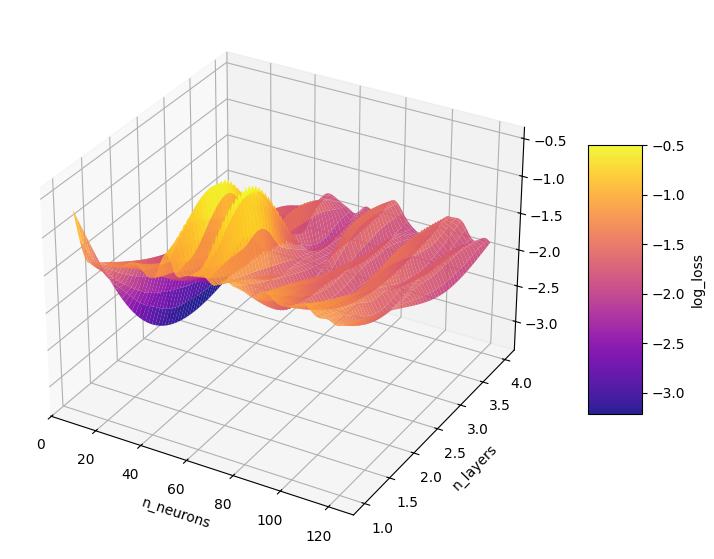

In [ ]:

df_xgb = pd.read_csv('/content/drive/MyDrive/Thesis/BO_Results/XGB_grid_metrics.csv')

x = df_xgb['max_depth'].values
y = df_xgb['n_estimators'].values
z = -df_xgb['log_loss'].values

# Feineres Raster
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
XI, YI = np.meshgrid(xi, yi)

# Interpolation
ZI = griddata((x, y), z, (XI, YI), method='cubic')

# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XI, YI, ZI, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
fig.colorbar(surf, shrink=0.5, aspect=5, label='log_loss')
plt.savefig(f"{output_dir}/XGB_landscape_log_loss.png")
plt.show()

# ================================
#  Neural Network 3D-Landschaft
# ================================
df_nn = pd.read_csv('/content/drive/MyDrive/Thesis/BO_Results/NN_grid_metrics.csv')

x = df_nn['n_neurons'].values
y = df_nn['n_layers'].values
z = -df_nn['log_loss'].values

# Feineres Raster
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
XI, YI = np.meshgrid(xi, yi)

# Interpolation
ZI = griddata((x, y), z, (XI, YI), method='cubic')

# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XI, YI, ZI, cmap='plasma', edgecolor='none', alpha=0.9)
ax.set_xlabel('n_neurons')
ax.set_ylabel('n_layers')
fig.colorbar(surf, shrink=0.5, aspect=5, label='log_loss')
plt.savefig(f"{output_dir}/NN_landscape_log_loss.png")
plt.show()
